# Mask R-CNN - Train on OpenImages Dataset

## Basic imports and constants

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from openimages2019 import setup as st
from openimages2019 import utils as u

from skimage.draw import rectangle

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

DATA_DIR = os.path.join(ROOT_DIR, "../data")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(DATA_DIR, "mask_rcnn_coco.h5")

#Make GPUs visible
!export HIP_VISIBLE_DEVICES=0,1,2,3



import mlflow
#add mlflow stuff

MLFLOW_SERVER = 'occ01ap200.na.simplot.com'

os.environ['NO_PROXY'] = MLFLOW_SERVER
mlflow.tracking.set_tracking_uri('http://' + MLFLOW_SERVER + ':5005')
EXPERIMENT_NAME = 'kaggle_openimage_mask_rcnn_v1.0'
mlflow.set_experiment(EXPERIMENT_NAME)

# os.environ['AZURE_STORAGE_ACCESS_KEY'] = ''


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Using TensorFlow backend.


## General Train functions

In [3]:
class TrainConfig(Config):
    
    NAME = "kaggle"
    GPU_COUNT = 2
    IMAGES_PER_GPU = 2
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    STEPS_PER_EPOCH = 500
    

def log_params(pz):
    for k,v in pz.items():
        mlflow.log_param(k,v)

def get_infer_model(config, model_path=None):
    inf_model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

    if model_path is None:
        model_path = inf_model.find_last()
        
    inf_model.load_weights(model_path, by_name=True)
    
    return inf_model
        

def train(model, inf_config, train_data, val_data, params):
    with mlflow.start_run():
        
        model.train(train_data, val_data, 
                    learning_rate=params['learning_rate'], 
                    epochs=params['epochs'], 
                    layers=params['layers'])

        log_params(params)
        
        #Inference to get mAP
        inf_model = modellib.MaskRCNN(mode="inference", config=inf_config, model_dir=MODEL_DIR)
        model_path = inf_model.find_last()
        inf_model.load_weights(model_path, by_name=True)
        mAP = u.eval_mAP(inf_model, val_data, inf_config, params['mAP_sample_size'])
        
        mlflow.log_metric('mAP', mAP)
        mlflow.log_param('Model Path', model_path)
        
        # pickle.dump(clf,open(model_filepath,'wb'))
        # mlflow.log_artifact(model_filepath)
        
        return model_path, mAP

    
    
def train_on_class_subset(class_set, params, init_with="coco"):
    
    class KaggleConfig(TrainConfig):
        NUM_CLASSES = len(class_set) + 1 # + 1 for background class

    class InferenceConfig(KaggleConfig):
        GPU_COUNT = 1
        BATCH_SIZE = 10

    train_config = KaggleConfig()
    inf_config = InferenceConfig()    

    model = modellib.MaskRCNN(mode="training", config=train_config, model_dir=MODEL_DIR)

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        model.load_weights(model.find_last(), by_name=True)
    
    anns = st.load_annotations_by_image(class_set)
    train_data = st.load_dataset(anns, DATA_DIR, class_set, is_train=True)
    val_data = st.load_dataset(anns, DATA_DIR, class_set, is_train=False)

    return train(model, inf_config, train_data, val_data, params)

## Partition the classes according to frequency

In [38]:
conn = st._get_sql_conn()

all_classes = st.load_classes(conn)
bboxes = pd.read_sql("SELECT ImageID, XMax, XMin, YMin, YMax, LabelName FROM [Sandbox].[kaggle].[Combined_Set_Detection_BBox]", conn)

tmp = bboxes['LabelName'].value_counts()
tmp = tmp.apply(np.log10)
tmp = tmp.apply(int)

class_sets = []

for i in range(1,7):
    idxs = tmp[tmp == i].index.values
    tmp_set = all_classes[all_classes['LabelName'].isin(idxs)]  #reset_index()
    tmp_set = tmp_set.reset_index()
    tmp_set['LabelID'] = tmp_set.index + 1
    class_sets.append(tmp_set)

## Train a model on each partition

In [ ]:
params = {'learning_rate' : 0.001,
          'epochs' : 25,
          'layers' : 'heads',
          'mAP_sample_size' : 250
         }

for i,class_set in enumerate(class_sets):
    params['class_set_index'] = i
    x = train_on_class_subset(class_set, params)
    print(x)

#see mlflow for results

# anns = st.load_annotations_by_image(class_set)
# train_data = st.load_dataset(anns, DATA_DIR, class_set, is_train=True)
# val_data = st.load_dataset(anns, DATA_DIR, class_set, is_train=False)

## Combine results

### Build models for each class set

In [75]:
#update class names

omni_classes = []

for cset in class_sets:
    omni_classes.insert('',var)

class_sets[0]


index   LabelName LabelDescription  LabelID
0      3   /m/01kb5b       Flashlight        1
1     34   /m/01k6s3          Toaster        2
2     42    /m/07dd4            Torch        3
3    133   /m/04zwwv      Ring binder        4
4    316   /m/02d1br          Spatula        5
5    352  /m/0h8ntjv  Pressure cooker        6
6    366   /m/01bms0      Screwdriver        7
7    404   /m/02cvgx     Winter melon        8
8    459   /m/07v9_z    Measuring cup        9

In [41]:
# class KaggleConfig(TrainConfig):
#         NUM_CLASSES = len(class_sets[3])+ 1 # + 1 for background class

# class InferenceConfig(KaggleConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inf_config = InferenceConfig()  


model_paths = ['kaggle20190815T2120/mask_rcnn_kaggle_0025.h5','kaggle20190815T2229/mask_rcnn_kaggle_0025.h5',
               'kaggle20190815T2347/mask_rcnn_kaggle_0025.h5','kaggle20190816T0115/mask_rcnn_kaggle_0025.h5',
               'kaggle20190816T0256/mask_rcnn_kaggle_0025.h5']

models = []

for i,mpath in enumerate(model_paths):
    
    class KaggleConfig(TrainConfig):
        NUM_CLASSES = len(class_sets[i])+ 1 # + 1 for background class

    class InferenceConfig(KaggleConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1  #TODO mod this if needed

    inf_config = InferenceConfig()

    models.append(get_infer_model(inf_config,model_path=os.path.join(MODEL_DIR, mpath)))




Re-starting from epoch 25
Re-starting from epoch 25
Re-starting from epoch 25
Re-starting from epoch 25
Re-starting from epoch 25


### Visualize


*** No instances to display *** 



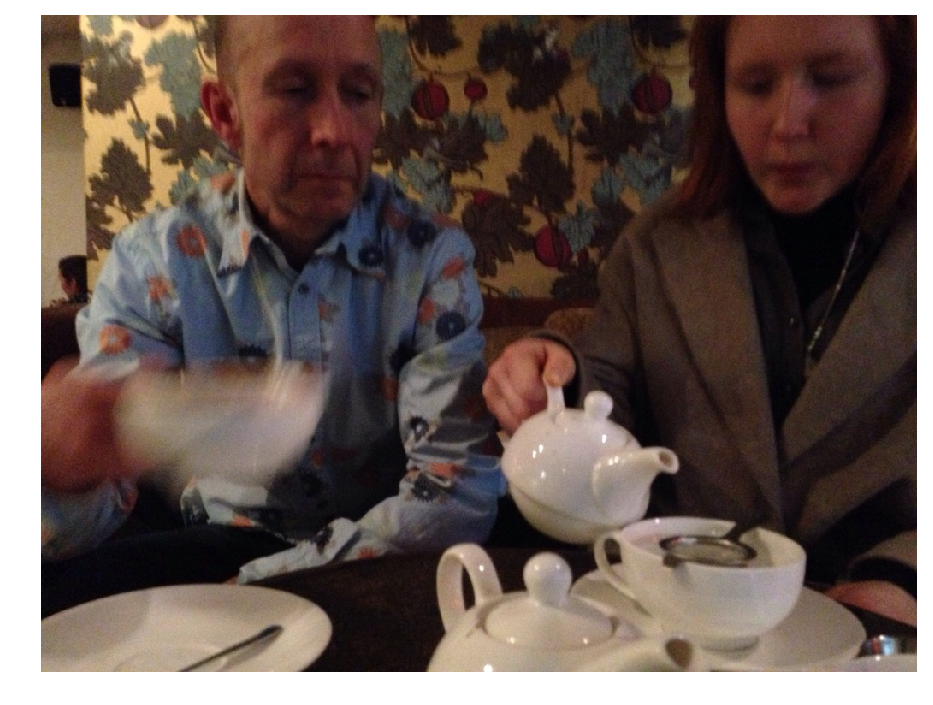

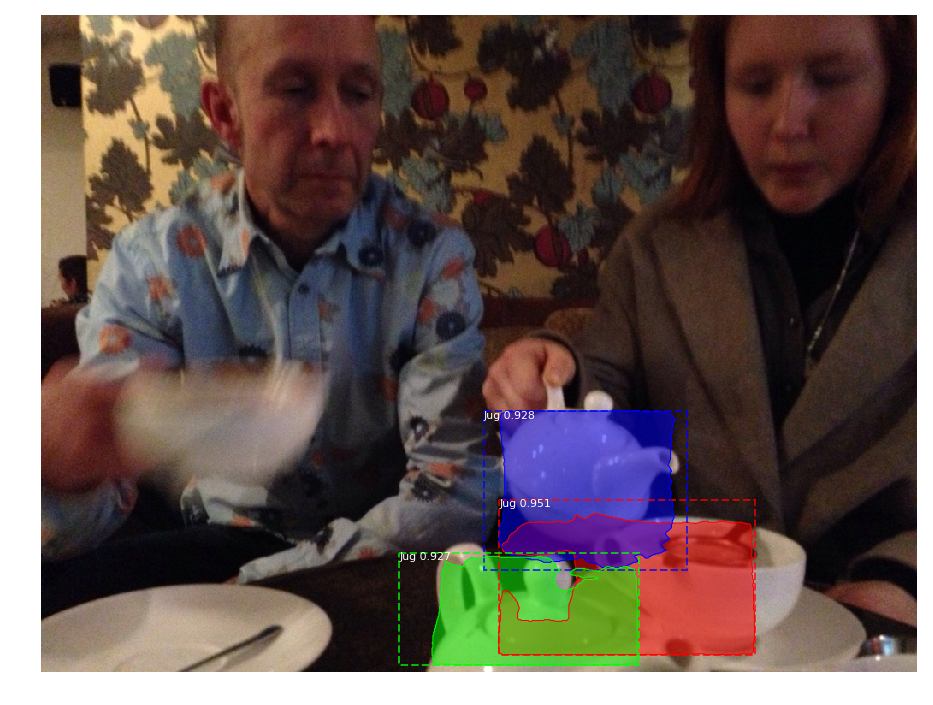

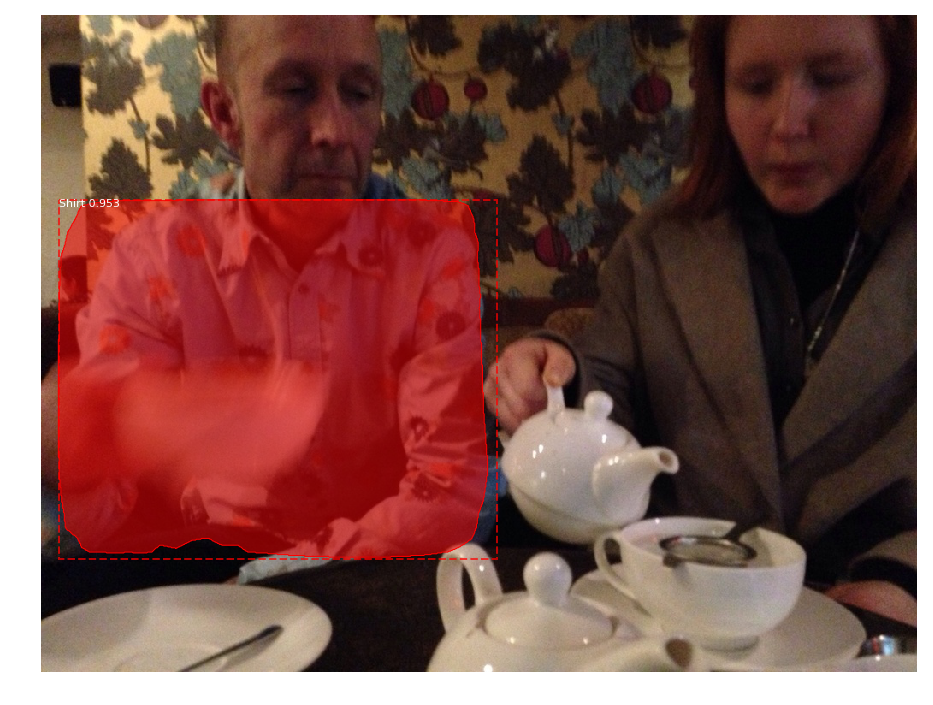

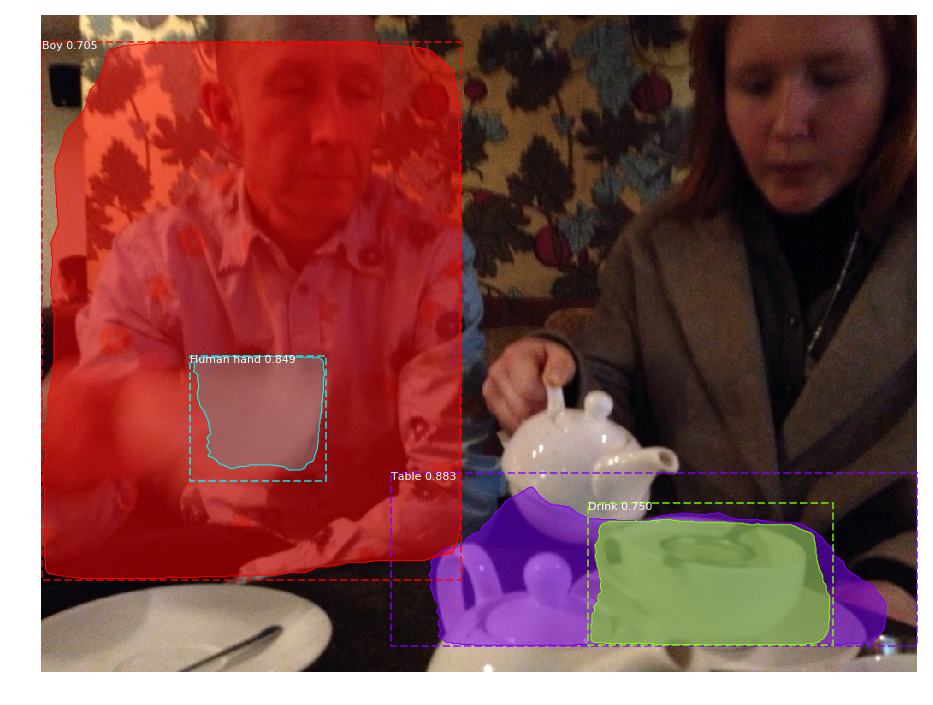

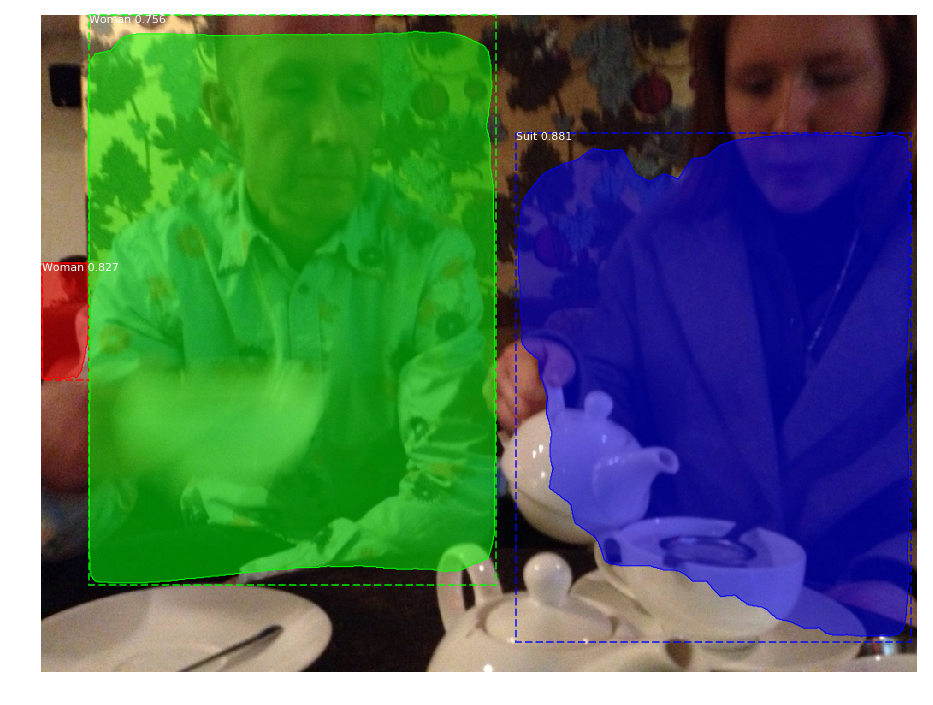

In [53]:
import skimage

# test on a few random images
# image_ids = np.random.choice(dataset_val.image_ids, inference_config.BATCH_SIZE)

# images = [skimage.io.imread(os.path.join(DATA_DIR, rel_path)) for rel_path in ]

img = skimage.io.imread(os.path.join(DATA_DIR, 'train/2fef4dd2f83feb18.jpg'))

images = [img]

all_results = []

for midx,model in enumerate(models):

    results = model.detect(images, verbose=0)
    class_names = np.insert(class_sets[midx]['LabelDescription'].values, 0, 'Background')

    for i in range(len(results)):
        r = results[i]
        all_results += results
        visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [54]:
all_results

[{'class_ids': array([], dtype=int32),
  'masks': array([], shape=(768, 1024, 0), dtype=float64),
  'rois': array([], shape=(0, 4), dtype=int32),
  'scores': array([], dtype=float32)},
 {'class_ids': array([176, 176, 176], dtype=int32),
  'masks': array([[[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],
  
         [[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],
  
         [[False, False, False],
          [False, False, False],
          [False, False, False],
          ...,
          [False, False, False],
          [False, False, False],
          [False, False, False]],
  
         ...,
  
         [[False, False, False],
          [False, False, False],
          [False, Fa

### Non maximum suppression

In [73]:
#1,3 

r1 = all_results[1]
r3 = all_results[3]

scores = np.concatenate([r1['scores'],r3['scores']])

threshold = 0.2 #TODO use this to check on things

boxes = np.concatenate([r1['rois'],r3['rois']],axis = 0)

to_keep = utils.non_max_suppression(boxes, scores, threshold)

#TODO keep class ids here as well

# scores

# Get the class ids, rois, and scores and then calculate IoU

array([0, 4, 6], dtype=int32)

In [74]:
class_sets[0]
#TODO update class_ids and class_names

# r['class_ids'] are indices into class_names

index   LabelName LabelDescription  LabelID
0      3   /m/01kb5b       Flashlight        1
1     34   /m/01k6s3          Toaster        2
2     42    /m/07dd4            Torch        3
3    133   /m/04zwwv      Ring binder        4
4    316   /m/02d1br          Spatula        5
5    352  /m/0h8ntjv  Pressure cooker        6
6    366   /m/01bms0      Screwdriver        7
7    404   /m/02cvgx     Winter melon        8
8    459   /m/07v9_z    Measuring cup        9

In [ ]:
img = skimage.io.imread(os.path.join(DATA_DIR, 'train/2fef4dd2f83feb18.jpg'))

images = [img]

#TODO create single class list
#TODO mock masks or just create all false masks (all empty, since this is object detection)

# results = model.detect(images, verbose=0)
class_names = np.insert(class_sets[midx]['LabelDescription'].values, 0, 'Background')

for i in range(len(results)):
    r = results[i]
    visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

    